In [1]:
import scipy.stats as st
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Data load

In [2]:
# Description des champs
# https://opendatanetwork.herokuapp.com/dataset/data.seattle.gov/h7rm-fz6m

# Premier jeu de données
data_2015 = pd.read_csv('2015-building-energy-benchmarking.csv',
                        sep=',', decimal='.', encoding='utf8', low_memory=False)
# Second jeu de données
data_2016 = pd.read_csv('2016-building-energy-benchmarking.csv',
                        sep=',', decimal='.', encoding='utf8', low_memory=False)

# Dataframes reconciliation

## Dataframes description

In [3]:
data_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [4]:
data_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

## Dataframe data_2015

### Columns available in data_2015 and not in data_2016

In [5]:
temp = [x for x in data_2015.columns if x not in data_2016.columns]
print(temp)

['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes']


### Columns processing

#### Location

In [6]:
data_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

In [7]:
print(data_2016['Latitude'][0])
print(data_2016['Longitude'][0])
print(data_2016['Address'][0])
print(data_2016['City'][0])
print(data_2016['State'][0])
print(data_2016['ZipCode'][0])

47.6122
-122.33799
405 Olive way
Seattle
WA
98101.0


In [8]:
def LocationDecomposition(_df):
    # FIRST PART

    # Replace \' by "
    replaced = _df['Location'].replace("\'", '"')
    # Find position of coma
    position = [pos for pos, char in enumerate(replaced) if char == ',']
    # Convert to dictionary
    res1 = json.loads(replaced[0:position[1]] + '}')

    # SECOND PART

    second_part = replaced[position[1]:]
    # Find position of accolades
    position1 = [pos for pos, char in enumerate(second_part) if char == '{']
    position2 = [pos for pos, char in enumerate(second_part) if char == '}']
    second_part = second_part[position1[0]:position2[0]+1]
    # Convert to dictionary
    res2 = json.loads(second_part)

    # Merge the 2 dictionaries
    res1.update(res2)

    return res1

In [9]:
def GetLatitudeFromLocation(_def):
    res = LocationDecomposition(_def)
    return res['latitude']


data_2015['Latitude'] = data_2015.apply(GetLatitudeFromLocation, axis=1)

In [10]:
def GetLongitudeFromLocation(_def):
    res = LocationDecomposition(_def)
    return res['longitude']


data_2015['Longitude'] = data_2015.apply(GetLongitudeFromLocation, axis=1)

In [11]:
def GetAddressFromLocation(_def):
    res = LocationDecomposition(_def)
    return res['address']


data_2015['Address'] = data_2015.apply(GetAddressFromLocation, axis=1)

In [12]:
def GetCityFromLocation(_def):
    res = LocationDecomposition(_def)
    return res['city']


data_2015['City'] = data_2015.apply(GetCityFromLocation, axis=1)

In [13]:
def GetStateFromLocation(_def):
    res = LocationDecomposition(_def)
    return res['state']


data_2015['State'] = data_2015.apply(GetStateFromLocation, axis=1)

In [14]:
def GetZipFromLocation(_def):
    res = LocationDecomposition(_def)
    return res['zip']


data_2015['ZipCode'] = data_2015.apply(GetZipFromLocation, axis=1)

In [15]:
data_2015 = data_2015.drop('Location', 1)

#### OtherFuelUse(kBtu)

In [16]:
data_2015 = data_2015.drop('OtherFuelUse(kBtu)', 1)

#### GHGEmissions(MetricTonsCO2e)

In [17]:
data_2015['GHGEmissions(MetricTonsCO2e)'][0:5]

0     249.43
1     263.51
2    2061.48
3    1936.34
4     507.70
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

In [18]:
data_2015['GHGEmissions(MetricTonsCO2e)'].describe()

count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

In [19]:
data_2016['TotalGHGEmissions'][0:5]

0     249.98
1     295.86
2    2089.28
3     286.43
4     505.01
Name: TotalGHGEmissions, dtype: float64

In [20]:
data_2016['TotalGHGEmissions'][0:5].describe()

count       5.00000
mean      685.31200
std       791.19034
min       249.98000
25%       286.43000
50%       295.86000
75%       505.01000
max      2089.28000
Name: TotalGHGEmissions, dtype: float64

In [21]:
data_2015 = data_2015.rename(
    columns={"GHGEmissions(MetricTonsCO2e)": "TotalGHGEmissions"})

#### GHGEmissionsIntensity(kgCO2e/ft2)

In [22]:
data_2015['GHGEmissionsIntensity(kgCO2e/ft2)'][0:5]

0     2.64
1     2.38
2     1.92
3    31.38
4     4.02
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64

In [23]:
data_2015['GHGEmissionsIntensity(kgCO2e/ft2)'][0:5].describe()

count     5.000000
mean      8.468000
std      12.832089
min       1.920000
25%       2.380000
50%       2.640000
75%       4.020000
max      31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64

In [24]:
data_2016['GHGEmissionsIntensity'][0:5]

0    2.83
1    2.86
2    2.19
3    4.67
4    2.88
Name: GHGEmissionsIntensity, dtype: float64

In [25]:
data_2016['GHGEmissionsIntensity'][0:5].describe()

count    5.00000
mean     3.08600
std      0.93152
min      2.19000
25%      2.83000
50%      2.86000
75%      2.88000
max      4.67000
Name: GHGEmissionsIntensity, dtype: float64

In [26]:
data_2015 = data_2015.rename(
    columns={"GHGEmissionsIntensity(kgCO2e/ft2)": "GHGEmissionsIntensity"})

#### Comment

In [27]:
print('Taux de remplissage: ' +
      str((round(data_2015['Comment'].notnull().sum()/len(data_2015), 3))*100)+'%')

Taux de remplissage: 0.4%


In [28]:
data_2015 = data_2015.drop('Comment', 1)

#### 2010 Census Tracts

In [29]:
data_2015 = data_2015.drop('2010 Census Tracts', 1)

#### Seattle Police Department Micro Community Policing Plan Areas

In [30]:
data_2015 = data_2015.drop(
    'Seattle Police Department Micro Community Policing Plan Areas', 1)

#### City Council Districts

In [31]:
data_2015 = data_2015.drop('City Council Districts', 1)

#### SPD Beats

In [32]:
data_2015 = data_2015.drop('SPD Beats', 1)

#### Zip Codes

In [33]:
data_2015 = data_2015.drop('Zip Codes', 1)

### Check point

In [34]:
temp = [x for x in data_2015.columns if x not in data_2016.columns]
print(temp)

[]


## Dataframe data_2016

### Columns available in data_2016 and not in data_2015

In [35]:
temp = [x for x in data_2016.columns if x not in data_2015.columns]
print(temp)

['Comments']


In [36]:
data_2016 = data_2016.drop('Comments', 1)

### Check point

In [37]:
temp = [x for x in data_2016.columns if x not in data_2015.columns]
print(temp)

[]


## Concatenation

In [38]:
data = pd.concat([data_2015, data_2016], axis=0, ignore_index=True)

# Data exploration

## Shape Analysis

### Variables

In [39]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData',
       'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude', 'Address'

### Target variables

### Rows and cols

In [40]:
data.shape

(6716, 45)

### Variable types

In [41]:
data.dtypes.value_counts()

object     19
float64    19
int64       7
dtype: int64

### Missing values

<AxesSubplot:>

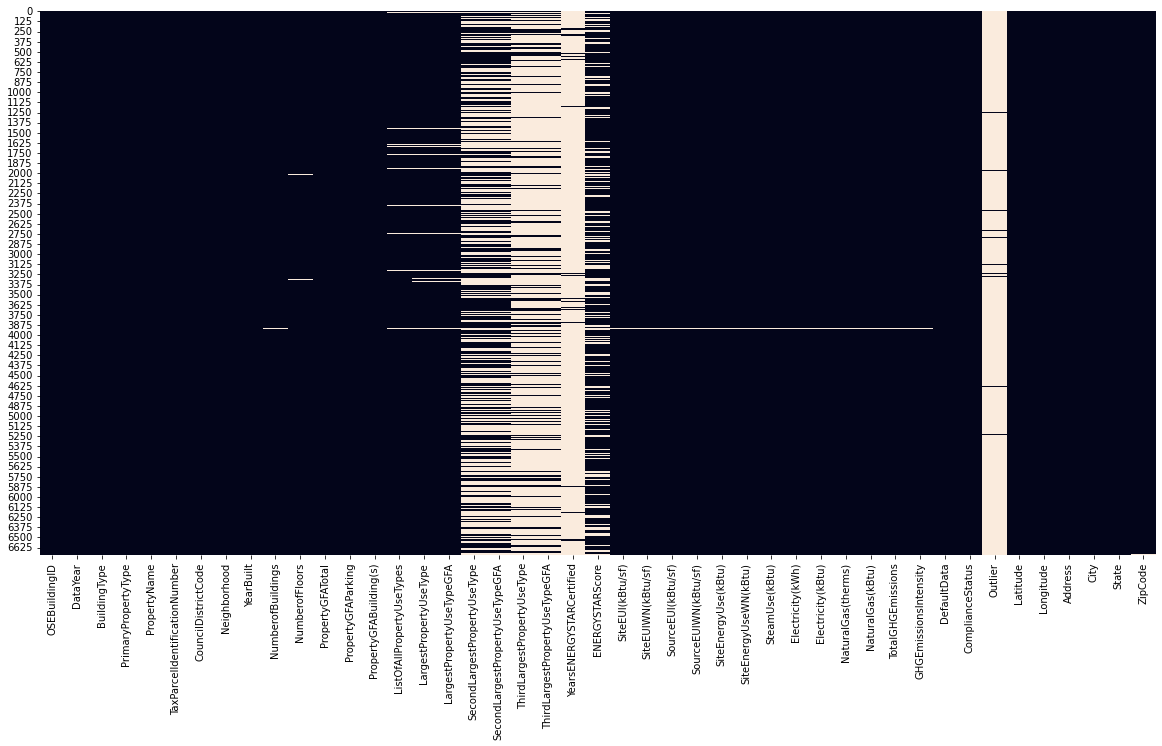

In [42]:
plt.figure(figsize=(20, 10))
sns.heatmap(data.isna(), cbar=False)

In [43]:
(data.isna().sum()/data.shape[0]).sort_values(ascending=True)

OSEBuildingID                      0.000000
ComplianceStatus                   0.000000
Latitude                           0.000000
Longitude                          0.000000
Address                            0.000000
City                               0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
State                              0.000000
PropertyGFATotal                   0.000000
YearBuilt                          0.000000
Neighborhood                       0.000000
CouncilDistrictCode                0.000000
PropertyName                       0.000000
PrimaryPropertyType                0.000000
BuildingType                       0.000000
DataYear                           0.000000
DefaultData                        0.000149
TaxParcelIdentificationNumber      0.000298
NumberofFloors                     0.001191
NumberofBuildings                  0.001191
SiteEnergyUse(kBtu)                0.002233
SiteEnergyUseWN(kBtu)           

In [44]:
data['Outlier'].unique()

array([nan, 'High Outlier', 'Low Outlier', 'High outlier', 'Low outlier'],
      dtype=object)

## Background Analysis

### Targets visualization

#### SiteEnergyUse(kBtu)

In [45]:
data['SiteEnergyUse(kBtu)'].unique()

array([ 6981428.    ,  8354235.    , 73130656.    , ...,  5765898.    ,
         719471.1875,  1152896.25  ])

In [46]:
data['SiteEnergyUse(kBtu)'].describe()

count    6.701000e+03
mean     5.194673e+06
std      1.813648e+07
min      0.000000e+00
25%      9.200689e+05
50%      1.791071e+06
75%      4.135280e+06
max      8.739237e+08
Name: SiteEnergyUse(kBtu), dtype: float64

#### TotalGHGEmissions

In [47]:
data['TotalGHGEmissions'].unique()

array([ 249.43,  263.51, 2061.48, ...,  223.54,   22.11,   41.27])

In [48]:
data['TotalGHGEmissions'].describe()

count     6697.000000
mean       114.935638
std        478.876573
min         -0.800000
25%          9.450000
50%         33.180000
75%         91.530000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

## First cleaning

### Elimination of buildings intended for housing

In [49]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData',
       'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude', 'Address'

In [50]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [51]:
data = data[(data['BuildingType'] != 'Multifamily MR (5-9)') &
            (data['BuildingType'] != 'Multifamily LR (1-4)') &
            (data['BuildingType'] != 'Multifamily HR (10+)')
            ]
print(data.shape)

(3318, 45)


In [52]:
data = data[data['PrimaryPropertyType'] != 'Low-Rise Multifamily']
print(data.shape)

(3313, 45)


### Elimination of duplicates

In [53]:
data['OSEBuildingID'].duplicated().sum()

1617

In [54]:
data.drop_duplicates(subset='OSEBuildingID', keep='last', inplace=True)
print(data.shape)

(1696, 45)


### Low fill rate

In [55]:
data = data.drop('YearsENERGYSTARCertified', 1)
print(data.shape)

(1696, 44)


### Default data

In [56]:
data['DefaultData'].unique()

array(['No', 'Yes', False, True], dtype=object)

In [57]:
len(data[(data['DefaultData'] == True) | (data['DefaultData'] == 'Yes')])

93

In [58]:
data = data[(data['DefaultData'] == False) | (data['DefaultData'] == 'No')]
print(data.shape)

(1603, 44)


### Elimination of redundant columns

In [59]:
data['CouncilDistrictCode'].unique()

array([7, 3, 2, 4, 5, 6, 1], dtype=int64)

In [60]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'LAKE UNION', 'EAST', 'GREATER DUWAMISH', 'NORTHWEST',
       'SOUTHEAST', 'BALLARD', 'MAGNOLIA / QUEEN ANNE', 'NORTHEAST',
       'Central', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE', 'NORTH', 'North',
       'Delridge', 'Ballard', 'Northwest', 'DELRIDGE NEIGHBORHOODS'],
      dtype=object)

In [61]:
data['Latitude'].unique()

array(['47.61171108', '47.60679898', '47.6214758', ..., 47.59625,
       47.52832, 47.53939], dtype=object)

In [62]:
data['Longitude'].unique()

array(['-122.33681575', '-122.3371001', '-122.3430502', ..., -122.35784,
       -122.32431, -122.29536], dtype=object)

In [63]:
data['City'].unique()

array(['SEATTLE', 'Seattle'], dtype=object)

In [64]:
data['State'].unique()

array(['WA'], dtype=object)

In [65]:
data['ZipCode'].unique()

array(['98101', '98109', '98104', '98134', '98122', '98103', '98133',
       '98118', '98102', '98107', '98121', '98119', '98144', 98101.0,
       98121.0, 98104.0, 98154.0, 98105.0, 98112.0, 98109.0, 98070.0,
       98108.0, 98118.0, 98199.0, 98107.0, 98144.0, 98103.0, 98119.0,
       98136.0, 98122.0, 98126.0, 98133.0, 98146.0, 98033.0, 98106.0,
       98115.0, 98111.0, 98134.0, 98125.0, 98117.0, 98191.0, 98164.0,
       98195.0, 98185.0, 98181.0, 98102.0, 98168.0, 98155.0, 98006.0,
       98124.0, 98053.0, 98013.0, 98116.0, 98178.0, 98114.0, 98165.0,
       98011.0, 98113.0, 98177.0, 98020.0, 98145.0, nan], dtype=object)

In [66]:
data['Neighborhood'] = data['Neighborhood'].str.upper()

In [67]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'LAKE UNION', 'EAST', 'GREATER DUWAMISH', 'NORTHWEST',
       'SOUTHEAST', 'BALLARD', 'MAGNOLIA / QUEEN ANNE', 'NORTHEAST',
       'CENTRAL', 'SOUTHWEST', 'DELRIDGE', 'NORTH',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [68]:
data['Neighborhood'] = data['Neighborhood'].replace(
    'DELRIDGE NEIGHBORHOODS', 'DELRIDGE')

In [69]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'LAKE UNION', 'EAST', 'GREATER DUWAMISH', 'NORTHWEST',
       'SOUTHEAST', 'BALLARD', 'MAGNOLIA / QUEEN ANNE', 'NORTHEAST',
       'CENTRAL', 'SOUTHWEST', 'DELRIDGE', 'NORTH'], dtype=object)

### Elimination of useless columns

In [70]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'DefaultData', 'ComplianceStatus', 'Outlier', 'Latitude', 'Longitude',
       'Address', 'City', 'State', 'ZipCode'

In [71]:
columns_list = ['OSEBuildingID', 'DataYear', 'PropertyName', 'TaxParcelIdentificationNumber',
                'NumberofBuildings', 'DefaultData', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'City',
                'State', 'ZipCode', 'Address', 'SecondLargestPropertyUseType',
                'ThirdLargestPropertyUseType', 'ComplianceStatus']

for item in columns_list:
    data = data.drop(item, 1)
print(data.shape)

(1603, 28)


### Outliers

In [72]:
data['Outlier'].unique()

array([nan, 'Low Outlier', 'High outlier', 'Low outlier'], dtype=object)

In [73]:
data = data[data['Outlier'].isnull()]

In [74]:
data = data.drop('Outlier', 1)
print(data.shape)

(1587, 27)


In [75]:
data = data[data['TotalGHGEmissions'] >= 0]
print(data.shape)

(1584, 27)


### Missing values

In [76]:
data = data[data['LargestPropertyUseType'].notna()]
print(data.shape)

(1573, 27)


## Feature engineering

### Usage_nb

In [77]:
def isNaN(string):
    return string != string


def Usage(_df):
    if isNaN(_df['ListOfAllPropertyUseTypes']):
        return _df['ListOfAllPropertyUseTypes']
    else:
        usages = _df['ListOfAllPropertyUseTypes']
        str_usages = str(usages)

        return str_usages.count(',')+1


data['Usage_nb'] = data.apply(Usage, axis=1)

In [78]:
data['Usage_nb'].describe()

count    1573.000000
mean        1.938334
std         1.208278
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        11.000000
Name: Usage_nb, dtype: float64

In [79]:
data = data.drop('ListOfAllPropertyUseTypes', 1)

### Energy types used

In [80]:
data['SteamUse(kBtu)'].describe()

count    1.573000e+03
mean     5.580162e+05
std      5.698076e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.349435e+08
Name: SteamUse(kBtu), dtype: float64

In [81]:
def SteamUsed(_df):
    if _df['SteamUse(kBtu)'] != 0:
        return 1
    else:
        return 0


data['SteamUsed'] = data.apply(SteamUsed, axis=1)

In [82]:
data['SteamUsed'].describe()

count    1573.000000
mean        0.073109
std         0.260398
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SteamUsed, dtype: float64

In [83]:
def ElectricityUsed(_df):
    if _df['Electricity(kBtu)'] != 0:
        return 1
    else:
        return 0


data['ElectricityUsed'] = data.apply(ElectricityUsed, axis=1)

In [84]:
data['ElectricityUsed'].describe()

count    1573.000000
mean        0.993643
std         0.079504
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: ElectricityUsed, dtype: float64

In [85]:
def NaturalGasUsed(_df):
    if _df['NaturalGas(kBtu)'] != 0:
        return 1
    else:
        return 0


data['NaturalGasUsed'] = data.apply(NaturalGasUsed, axis=1)

In [86]:
data['NaturalGasUsed'].describe()

count    1573.000000
mean        0.710744
std         0.453561
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: NaturalGasUsed, dtype: float64

## Univariate analysis

In [87]:
def tableau(df, column):
    effectifs = df[column].value_counts()
    modalites = effectifs.index

    tab = pd.DataFrame(modalites, columns=[column])
    tab["n"] = effectifs.values
    tab["f"] = tab["n"] / len(df)
    tab = tab.sort_values('f')
    tab["F"] = tab["f"].cumsum()

    return tab

In [88]:
def univarie_qualitative(_df, _feature, _type, _title, _xlabel, _ylabel, _tab, _annot):
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    print(_feature)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    print('Distribution empirique')
    print('-----------------------------------------------------------')

    if _tab:
        print(tableau(_df, _feature))

    total = float(len(_df))
    if _type == 'pie':
        _df[_feature].value_counts(normalize=False).plot(kind=_type, title=_title, xlabel=_xlabel,
                                                         ylabel=_ylabel, autopct='%1.1f%%')
    else:
        ax = _df[_feature].value_counts(normalize=False).plot(kind=_type, title=_title,
                                                              xlabel=_xlabel, ylabel=_ylabel)
        if _annot:
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2., height + 3,
                        '{:1.2f}'.format((height/total)*100)+'%', ha="center")

    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.gcf().savefig('univarie_qualitative_' + _feature, dpi=100)
    plt.show()
    print('')
    print('-----------------------------------------------------------')
    print('Mode: ' + str(_df[_feature].mode()))
    print('')

### Qualitative variables

In [89]:
for col in data.select_dtypes('object'):
    print(f'{col :-<50} {data[col].unique().size}')

BuildingType-------------------------------------- 5
PrimaryPropertyType------------------------------- 22
Neighborhood-------------------------------------- 13
LargestPropertyUseType---------------------------- 57


-----------------------------------------------------------
-----------------------------------------------------------
BuildingType
-----------------------------------------------------------
-----------------------------------------------------------
Distribution empirique
-----------------------------------------------------------
         BuildingType     n         f         F
4   Nonresidential WA     1  0.000636  0.000636
3   SPS-District K-12    23  0.014622  0.015257
2              Campus    24  0.015257  0.030515
1  Nonresidential COS    81  0.051494  0.082009
0      NonResidential  1444  0.917991  1.000000


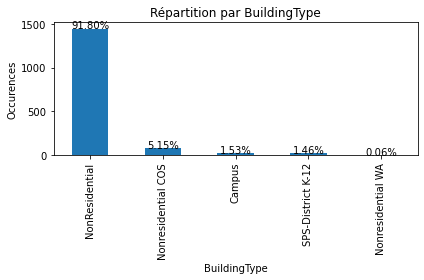


-----------------------------------------------------------
Mode: 0    NonResidential
dtype: object

-----------------------------------------------------------
-----------------------------------------------------------
PrimaryPropertyType
-----------------------------------------------------------
-----------------------------------------------------------
Distribution empirique
-----------------------------------------------------------
            PrimaryPropertyType    n         f         F
21                 Restaurant\n    1  0.000636  0.000636
20   Non-Refrigerated Warehouse    1  0.000636  0.001271
19                   Laboratory   10  0.006357  0.007629
18                     Hospital   10  0.006357  0.013986
17                   Restaurant   11  0.006993  0.020979
16       Refrigerated Warehouse   12  0.007629  0.028608
15        Senior Care Community   20  0.012715  0.041322
14               Residence Hall   21  0.013350  0.054673
13                   University   24  0.01

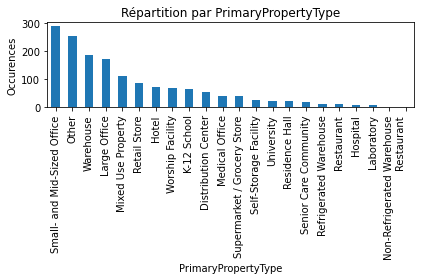


-----------------------------------------------------------
Mode: 0    Small- and Mid-Sized Office
dtype: object

-----------------------------------------------------------
-----------------------------------------------------------
Neighborhood
-----------------------------------------------------------
-----------------------------------------------------------
Distribution empirique
-----------------------------------------------------------
             Neighborhood    n         f         F
12              SOUTHWEST   32  0.020343  0.020343
11              SOUTHEAST   33  0.020979  0.041322
10               DELRIDGE   42  0.026701  0.068023
9                 CENTRAL   49  0.031151  0.099174
8                   NORTH   60  0.038144  0.137317
7                 BALLARD   65  0.041322  0.178640
6               NORTHWEST   80  0.050858  0.229498
5               NORTHEAST  117  0.074380  0.303878
4                    EAST  119  0.075652  0.379530
3              LAKE UNION  144  0.09154

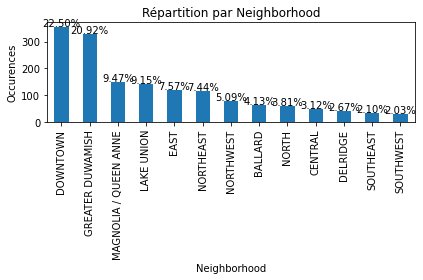


-----------------------------------------------------------
Mode: 0    DOWNTOWN
dtype: object

-----------------------------------------------------------
-----------------------------------------------------------
LargestPropertyUseType
-----------------------------------------------------------
-----------------------------------------------------------
Distribution empirique
-----------------------------------------------------------


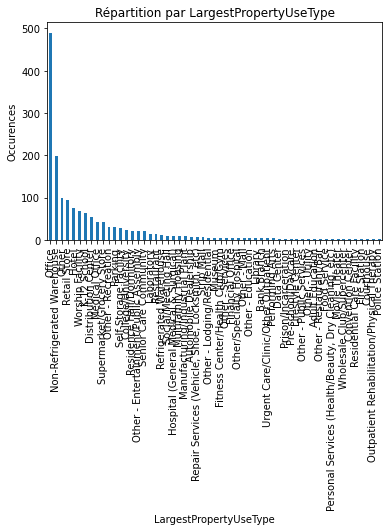


-----------------------------------------------------------
Mode: 0    Office
dtype: object

-----------------------------------------------------------
-----------------------------------------------------------
SteamUsed
-----------------------------------------------------------
-----------------------------------------------------------
Distribution empirique
-----------------------------------------------------------


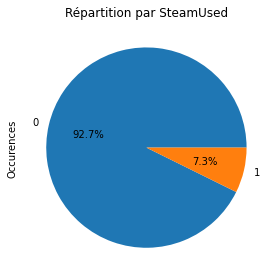


-----------------------------------------------------------
Mode: 0    0
dtype: int64

-----------------------------------------------------------
-----------------------------------------------------------
ElectricityUsed
-----------------------------------------------------------
-----------------------------------------------------------
Distribution empirique
-----------------------------------------------------------


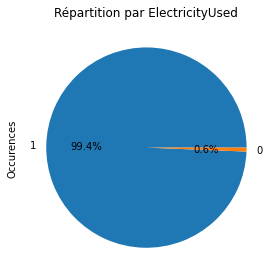


-----------------------------------------------------------
Mode: 0    1
dtype: int64

-----------------------------------------------------------
-----------------------------------------------------------
NaturalGasUsed
-----------------------------------------------------------
-----------------------------------------------------------
Distribution empirique
-----------------------------------------------------------


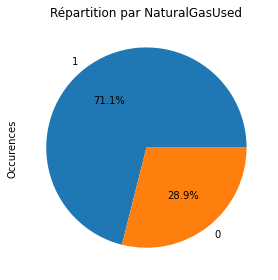


-----------------------------------------------------------
Mode: 0    1
dtype: int64



In [90]:
qualitatives = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
                'LargestPropertyUseType', 'SteamUsed', 'ElectricityUsed', 'NaturalGasUsed']

tab_qualitatives = {'BuildingType': True, 'PrimaryPropertyType': True, 'Neighborhood': True,
                    'LargestPropertyUseType': False, 'SteamUsed': False, 'ElectricityUsed': False,
                    'NaturalGasUsed': False}

chart_qualitatives = {'BuildingType': 'bar', 'PrimaryPropertyType': 'bar', 'Neighborhood': 'bar',
                      'LargestPropertyUseType': 'bar', 'SteamUsed': 'pie', 'ElectricityUsed': 'pie',
                      'NaturalGasUsed': 'pie'}

annot_qualitatives = {'BuildingType': True, 'PrimaryPropertyType': False, 'Neighborhood': True,
                      'LargestPropertyUseType': False, 'SteamUsed': True, 'ElectricityUsed': True,
                      'NaturalGasUsed': True}

for column in qualitatives:
    univarie_qualitative(data, column, chart_qualitatives[column], 'Répartition par ' + column,
                         column, 'Occurences', tab_qualitatives[column], annot_qualitatives[column])

### Quantitative variables

#### Surfaces

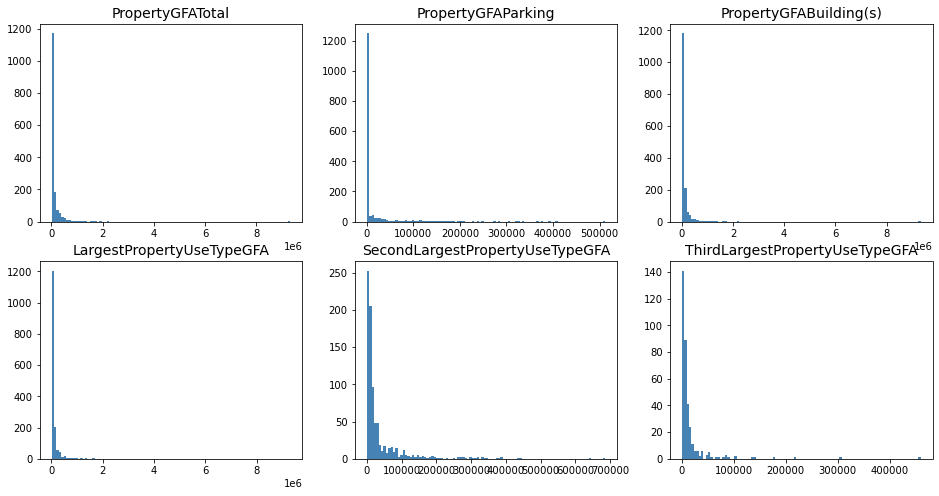

In [91]:
surface_column = ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                  'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                  'ThirdLargestPropertyUseTypeGFA']
X = data[surface_column].values

labels = surface_column

fig = plt.figure(figsize=(16, 8))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(2, 3, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=100, color='steelblue',
                density=False, edgecolor='none')
    ax.set_title(labels[feat_idx], fontsize=14)

In [92]:
for column in surface_column:
    print(data[column].describe())
    print('-------------------------------------------')

count    1.573000e+03
mean     1.221985e+05
std      3.062641e+05
min      1.128500e+04
25%      2.892000e+04
50%      4.878900e+04
75%      1.082450e+05
max      9.320156e+06
Name: PropertyGFATotal, dtype: float64
-------------------------------------------
count      1573.000000
mean      14068.186904
std       44753.266535
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64
-------------------------------------------
count    1.573000e+03
mean     1.081303e+05
std      2.923248e+05
min      3.636000e+03
25%      2.807200e+04
50%      4.648500e+04
75%      9.630000e+04
max      9.320156e+06
Name: PropertyGFABuilding(s), dtype: float64
-------------------------------------------
count    1.573000e+03
mean     1.007587e+05
std      2.846931e+05
min      5.656000e+03
25%      2.518400e+04
50%      4.250000e+04
75%      9.302000e+04
max      9.320156e+06
Name: LargestPropertyUseTypeGFA

#### Consumption readings

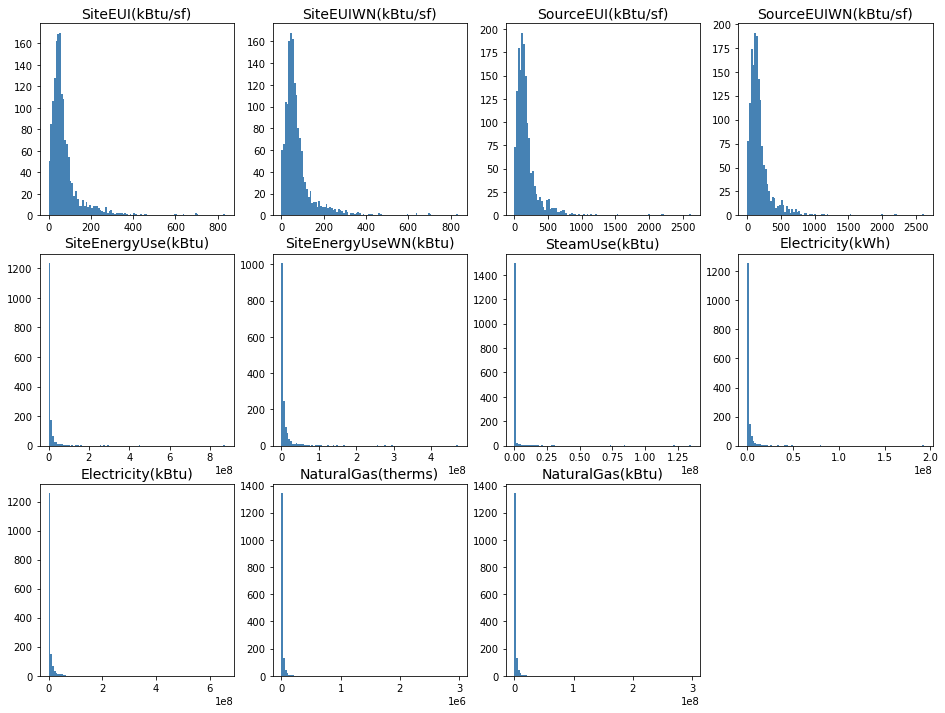

In [93]:
conso_column = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
                'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)']
X = data[conso_column].values

labels = conso_column

fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3, 4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=100, color='steelblue',
                density=False, edgecolor='none')
    ax.set_title(labels[feat_idx], fontsize=14)

In [94]:
for column in conso_column:
    print(data[column].describe())
    print('-------------------------------------------')

count    1572.000000
mean       74.960115
std        76.308736
min         0.000000
25%        34.475000
50%        53.599998
75%        85.400002
max       834.400024
Name: SiteEUI(kBtu/sf), dtype: float64
-------------------------------------------
count    1572.000000
mean       77.377481
std        77.488138
min         0.000000
25%        36.500000
50%        56.200001
75%        88.300003
max       834.400024
Name: SiteEUIWN(kBtu/sf), dtype: float64
-------------------------------------------
count    1573.000000
mean      182.368214
std       188.905310
min         0.000000
25%        79.599998
50%       138.100006
75%       212.100006
max      2620.000000
Name: SourceEUI(kBtu/sf), dtype: float64
-------------------------------------------
count    1573.000000
mean      184.518309
std       189.060111
min         0.000000
25%        82.000000
50%       141.100006
75%       215.000000
max      2620.000000
Name: SourceEUIWN(kBtu/sf), dtype: float64
--------------------------------

#### CO2 emission

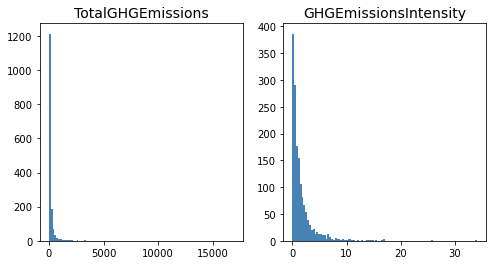

In [95]:
co2_column = ['TotalGHGEmissions', 'GHGEmissionsIntensity']
X = data[co2_column].values

labels = co2_column

fig = plt.figure(figsize=(8, 4))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(1, 2, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=100, color='steelblue',
                density=False, edgecolor='none')
    ax.set_title(labels[feat_idx], fontsize=14)

In [96]:
for column in co2_column:
    print(data[column].describe())
    print('-------------------------------------------')

count     1573.000000
mean       196.170464
std        783.031105
min          0.000000
25%         20.180000
50%         49.980000
75%        147.750000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64
-------------------------------------------
count    1573.000000
mean        1.669231
std         2.407877
min         0.000000
25%         0.350000
50%         0.880000
75%         1.980000
max        34.090000
Name: GHGEmissionsIntensity, dtype: float64
-------------------------------------------


#### Others

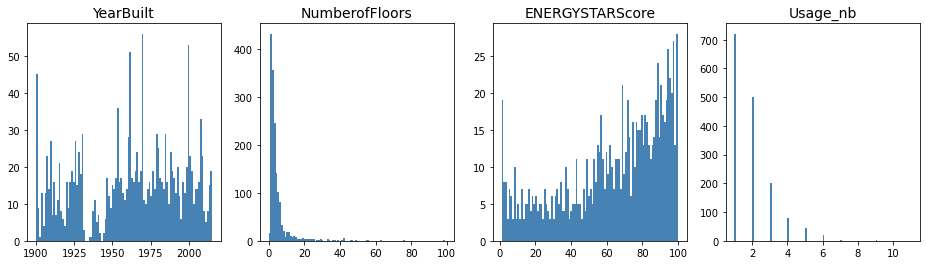

In [97]:
other_column = ['YearBuilt', 'NumberofFloors', 'ENERGYSTARScore', 'Usage_nb']
X = data[other_column].values

labels = other_column

fig = plt.figure(figsize=(16, 4))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(1, 4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=100, color='steelblue',
                density=False, edgecolor='none')
    ax.set_title(labels[feat_idx], fontsize=14)

In [98]:
for column in other_column:
    print(data[column].describe())
    print('-------------------------------------------')

count    1573.000000
mean     1961.653528
std        32.846781
min      1900.000000
25%      1930.000000
50%      1966.000000
75%      1989.000000
max      2015.000000
Name: YearBuilt, dtype: float64
-------------------------------------------
count    1573.000000
mean        4.249205
std         6.739062
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        99.000000
Name: NumberofFloors, dtype: float64
-------------------------------------------
count    1003.000000
mean       63.677966
std        28.735440
min         1.000000
25%        44.000000
50%        71.000000
75%        88.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64
-------------------------------------------
count    1573.000000
mean        1.938334
std         1.208278
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        11.000000
Name: Usage_nb, dtype: float64
-------------------------------------------


## Bivariate analysis

In [99]:
def bivarie_qualitative_continue(_df, _qualitative, _quantitative):
    X = _qualitative
    Y = _quantitative

    modalites = _df[X].unique()
    groupes = []
    for m in modalites:
        groupes.append(_df[_df[X] == m][Y])

    # Propriétés graphiques
    medianprops = {'color': "black"}
    meanprops = {'marker': 'o', 'markeredgecolor': 'black',
                 'markerfacecolor': 'firebrick'}

    plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops,
                vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.tight_layout()
    plt.gcf().savefig('bivarie_' + _qualitative + '_' + _quantitative, dpi=100)
    plt.show()

In [100]:
def bivarie_scatter(_df, _x, _y):
    area = (15 * np.random.rand(len(_df)))
    plt.scatter(_df[_x], _df[_y], s=area, alpha=0.5)
    plt.xlabel(_x)
    plt.ylabel(_y)
    plt.tight_layout()
    plt.gcf().savefig('bivarie_' + _x.replace('/', '') +
                      '_' + _y.replace('/', ''), dpi=100)
    plt.show()

In [101]:
def test_stat_continue_continue(_df, _xfeature, _yfeature, _bin):
    print('-----------------------------------------------------------')
    print('Covariance')
    print('-----------------------------------------------------------')
    print('Covariance: ' +
          str(np.cov(_df[_xfeature], _df[_yfeature], ddof=0)[1, 0]))
    print('')
    print('-----------------------------------------------------------')
    print('Coefficient de corrélation Pearson')
    print('-----------------------------------------------------------')
    if len(_df[_xfeature]) < 2:
        print('Calcul imossible, pas assez de données')
    else:
        stat, p = st.pearsonr(_df[_xfeature], _df[_yfeature])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Probablement indépendant')
        else:
            print('Probablement dépendant')
    print('')

### Qualitatives vs SiteEnergyUse

BuildingType


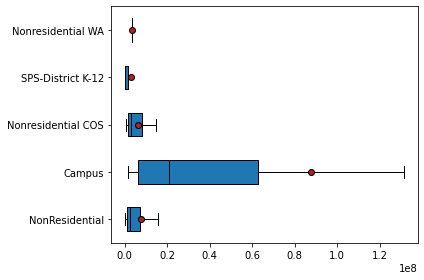

PrimaryPropertyType


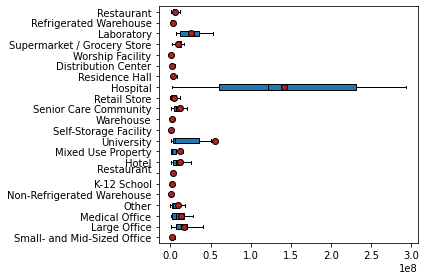

Neighborhood


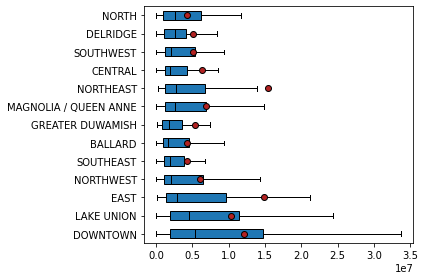

LargestPropertyUseType


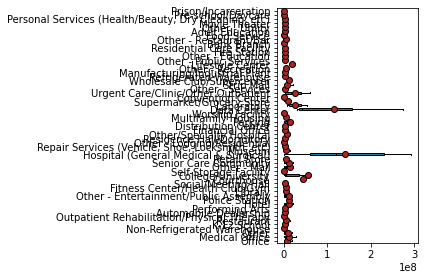

SteamUsed


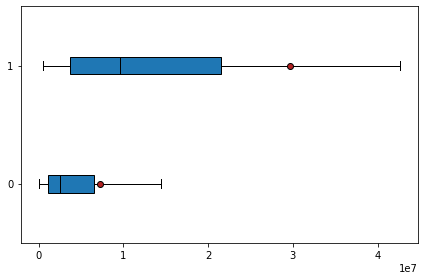

ElectricityUsed


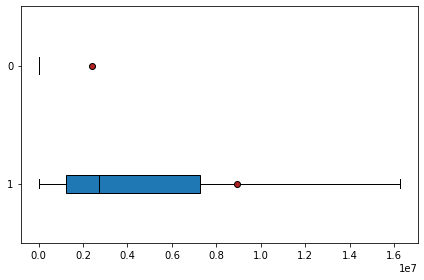

NaturalGasUsed


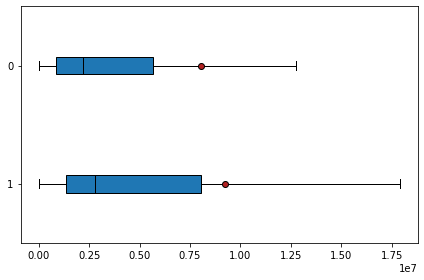

In [102]:
qualitatives = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
                'LargestPropertyUseType', 'SteamUsed', 'ElectricityUsed', 'NaturalGasUsed']

for column in qualitatives:
    print(column)
    bivarie_qualitative_continue(data, column, 'SiteEnergyUse(kBtu)')

### Qualitatives vs TotalGHGEmissions

BuildingType


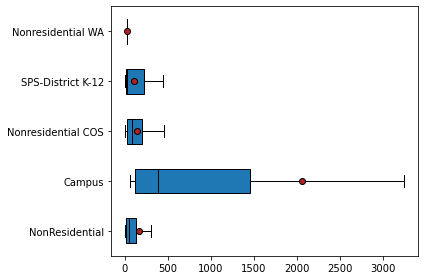

PrimaryPropertyType


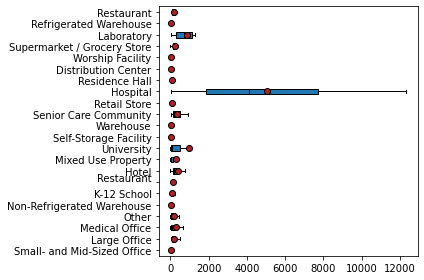

Neighborhood


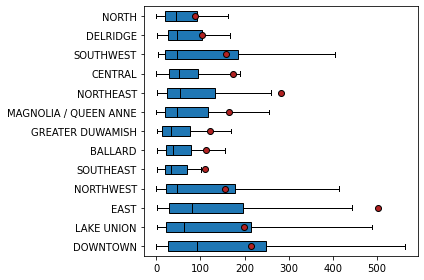

LargestPropertyUseType


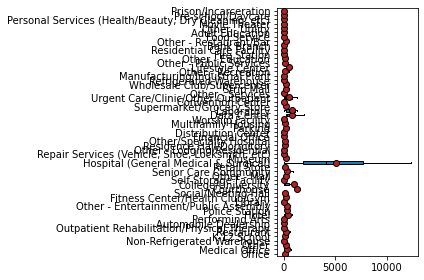

SteamUsed


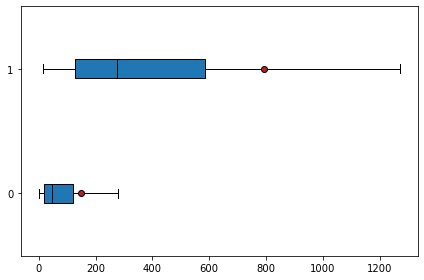

ElectricityUsed


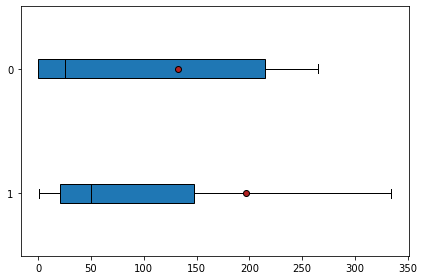

NaturalGasUsed


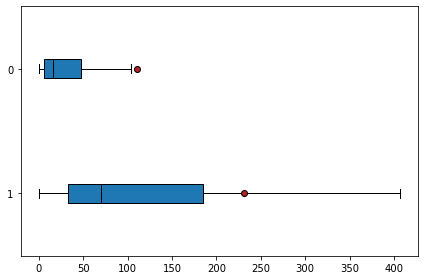

In [103]:
for column in qualitatives:
    print(column)
    bivarie_qualitative_continue(data, column, 'TotalGHGEmissions')

### Quantitatives vs SiteEnergyUse

YearBuilt


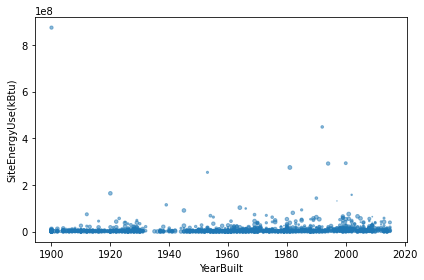

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 178447787.90216944

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.129, p=0.107
Probablement indépendant

NumberofFloors


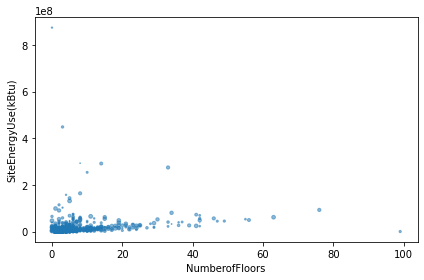

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 125724387.7444504

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.244, p=0.002
Probablement dépendant

PropertyGFATotal


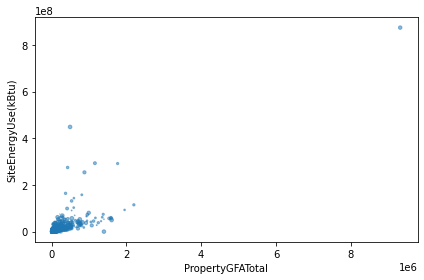

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 5518976390617.959

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.397, p=0.000
Probablement dépendant

PropertyGFAParking


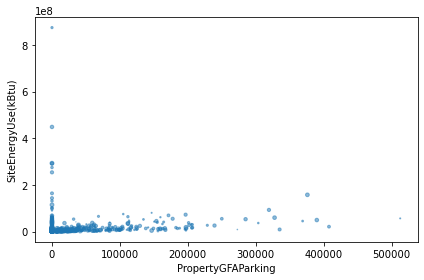

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 568920194616.2693

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.178, p=0.026
Probablement dépendant

PropertyGFABuilding(s)


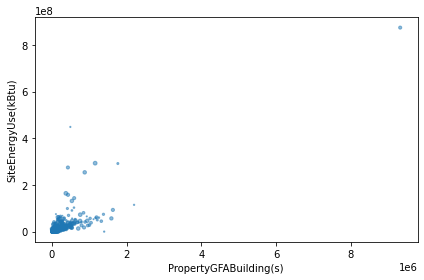

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 4950056196001.689

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.409, p=0.000
Probablement dépendant

LargestPropertyUseTypeGFA


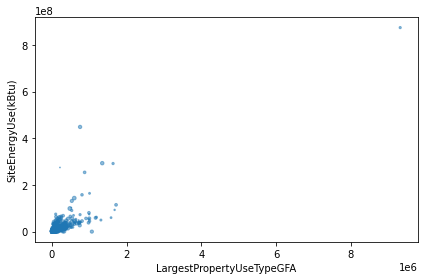

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 5390330845014.961

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.510, p=0.000
Probablement dépendant

SecondLargestPropertyUseTypeGFA


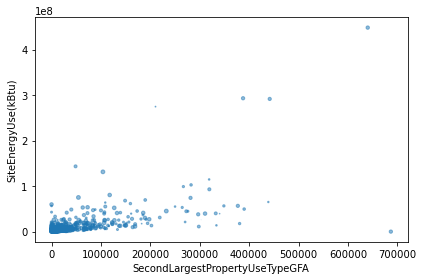

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 2682463671386.0757

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.706, p=0.000
Probablement dépendant

ThirdLargestPropertyUseTypeGFA


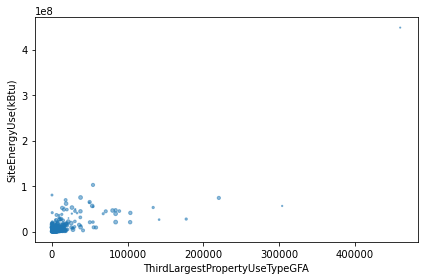

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 1541090956144.7874

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.775, p=0.000
Probablement dépendant

ENERGYSTARScore


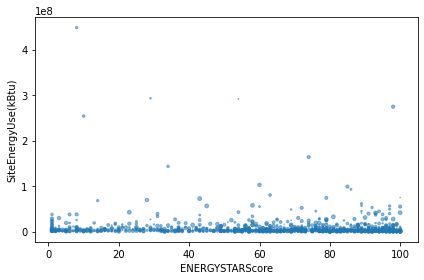

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: -114886282.25222476

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=-0.111, p=0.166
Probablement indépendant

SiteEUI(kBtu/sf)


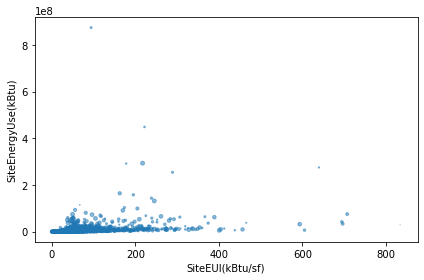

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 828508654.2176023

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.320, p=0.000
Probablement dépendant

SiteEUIWN(kBtu/sf)


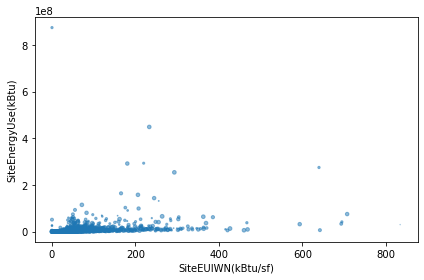

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 848114873.5351698

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.326, p=0.000
Probablement dépendant

SourceEUI(kBtu/sf)


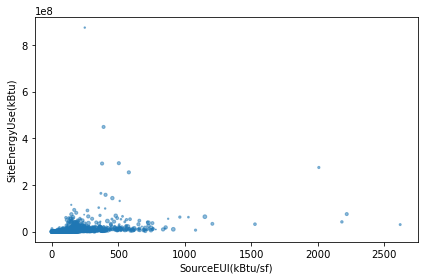

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 1776767055.8144805

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.231, p=0.004
Probablement dépendant

SourceEUIWN(kBtu/sf)


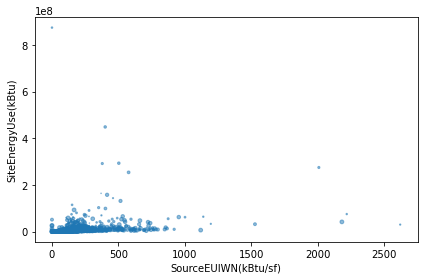

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 1793000478.8885324

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.233, p=0.003
Probablement dépendant

SiteEnergyUse(kBtu)


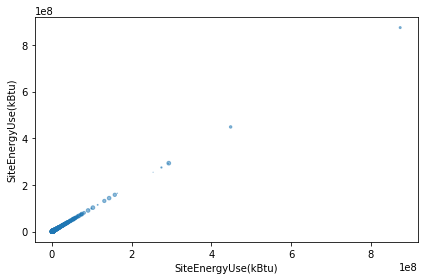

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 1513792618770840.5

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=1.000, p=0.000
Probablement dépendant

SiteEnergyUseWN(kBtu)


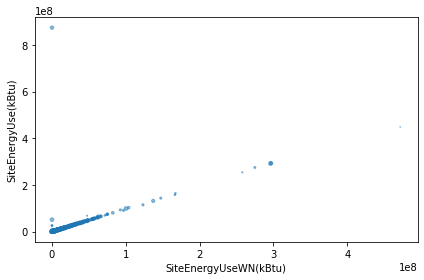

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 1581068913941223.5

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.999, p=0.000
Probablement dépendant

SteamUse(kBtu)


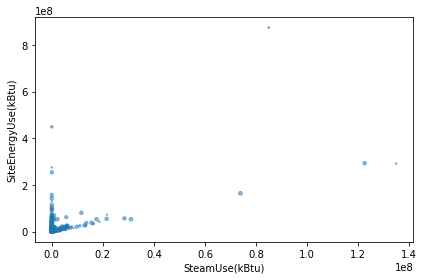

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 6091791396561.374

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.084, p=0.298
Probablement indépendant

Electricity(kWh)


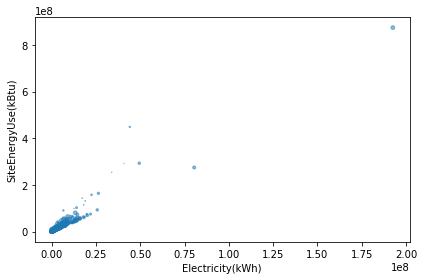

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 189811570479545.12

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.869, p=0.000
Probablement dépendant

Electricity(kBtu)


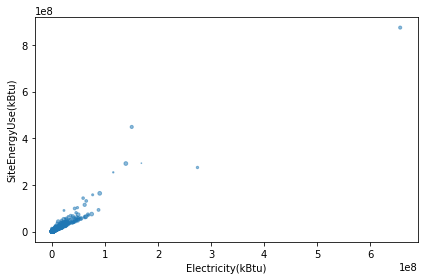

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 647637060831720.5

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.869, p=0.000
Probablement dépendant

NaturalGas(therms)


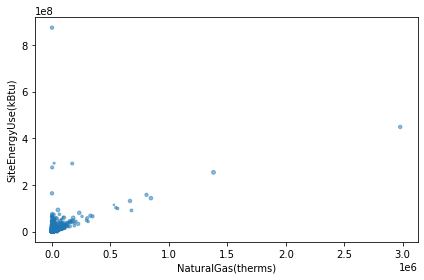

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 8606995920045.698

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.917, p=0.000
Probablement dépendant

NaturalGas(kBtu)


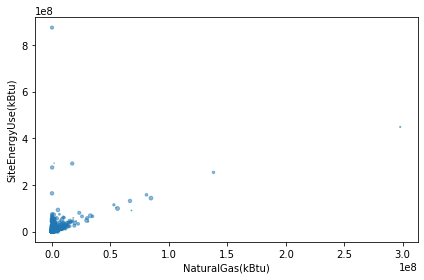

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 860699594616358.6

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.917, p=0.000
Probablement dépendant

TotalGHGEmissions


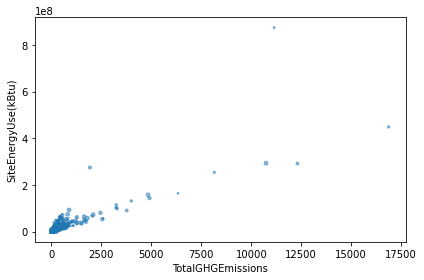

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 50696908527.36511

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.948, p=0.000
Probablement dépendant

GHGEmissionsIntensity


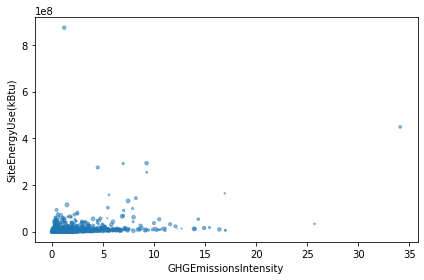

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 94512996.89562678

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.860, p=0.000
Probablement dépendant

Usage_nb


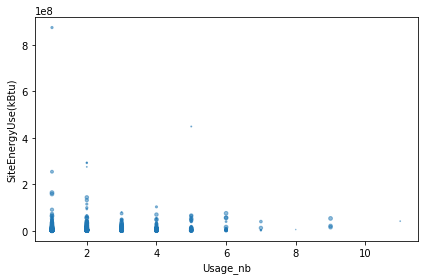

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 10548655.721493246

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.260, p=0.001
Probablement dépendant



In [104]:
column_list = ['YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
               'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
               'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
               'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
               'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
               'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
               'Usage_nb'
               ]

for column in column_list:
    print(column)
    bivarie_scatter(data, column, 'SiteEnergyUse(kBtu)')
    test_stat_continue_continue(
        data.dropna(), column, 'SiteEnergyUse(kBtu)', 100)

### Quantitatives vs TotalGHGEmissions

YearBuilt


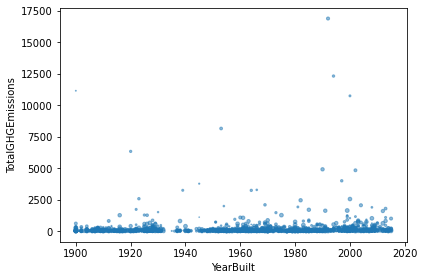

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 2822.831061706358

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.058, p=0.472
Probablement indépendant

NumberofFloors


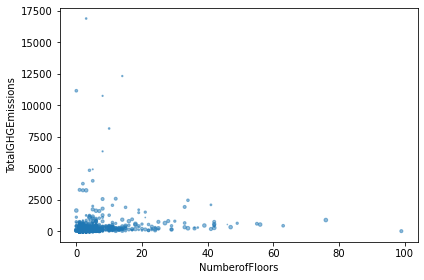

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 751.2673025274858

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.041, p=0.607
Probablement indépendant

PropertyGFATotal


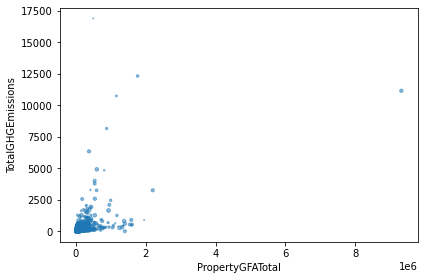

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 78417453.36044626

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.160, p=0.046
Probablement dépendant

PropertyGFAParking


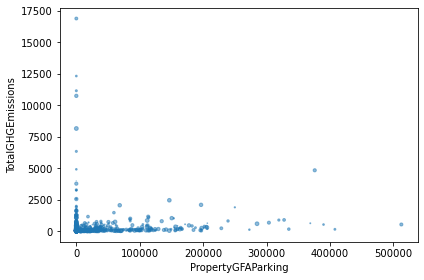

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 1671124.5456391752

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.015, p=0.854
Probablement indépendant

PropertyGFABuilding(s)


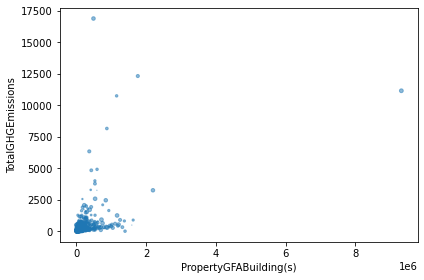

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 76746328.81480709

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.180, p=0.024
Probablement dépendant

LargestPropertyUseTypeGFA


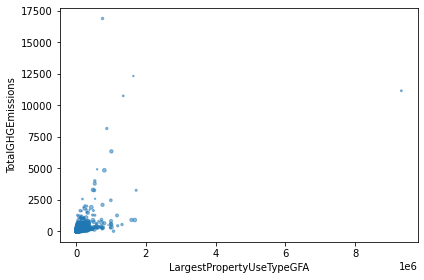

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 105946096.29187351

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.284, p=0.000
Probablement dépendant

SecondLargestPropertyUseTypeGFA


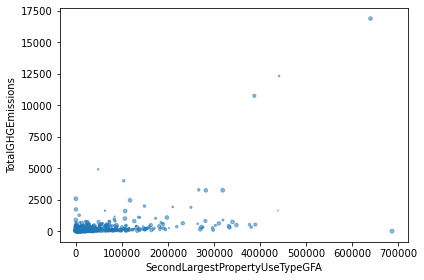

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 75206816.3624491

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.561, p=0.000
Probablement dépendant

ThirdLargestPropertyUseTypeGFA


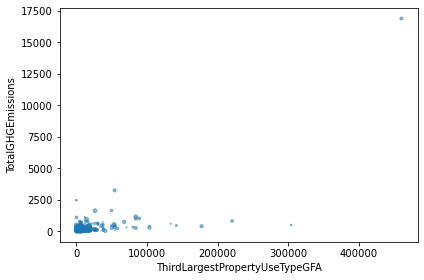

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 49947018.546770886

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.711, p=0.000
Probablement dépendant

ENERGYSTARScore


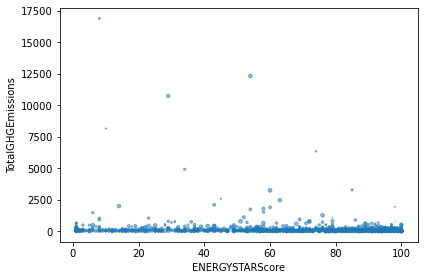

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: -6412.982655685827

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=-0.176, p=0.028
Probablement dépendant

SiteEUI(kBtu/sf)


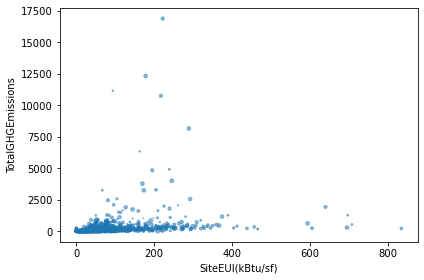

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 21053.433516843546

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.230, p=0.004
Probablement dépendant

SiteEUIWN(kBtu/sf)


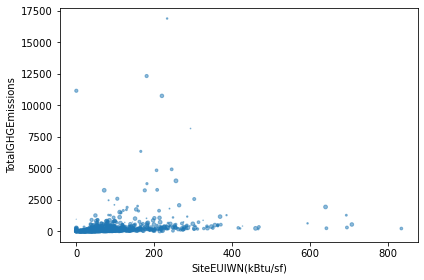

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 21780.336217017164

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.237, p=0.003
Probablement dépendant

SourceEUI(kBtu/sf)


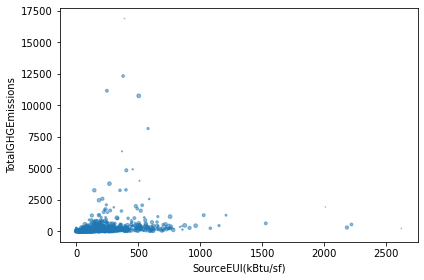

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 30589.837197104694

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.113, p=0.160
Probablement indépendant

SourceEUIWN(kBtu/sf)


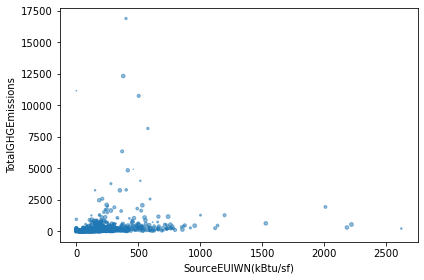

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 30717.86912597429

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.113, p=0.159
Probablement indépendant

SiteEnergyUse(kBtu)


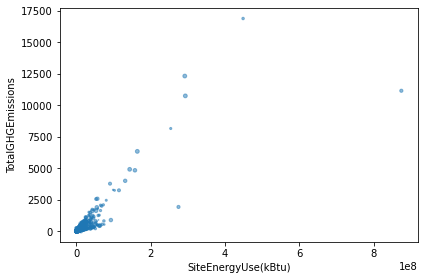

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 50696908527.36511

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.948, p=0.000
Probablement dépendant

SiteEnergyUseWN(kBtu)


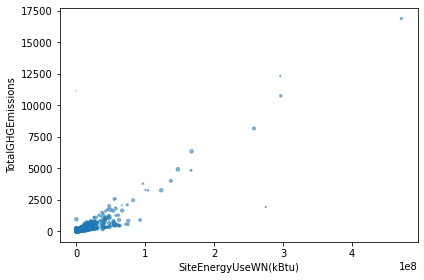

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 53125907885.36779

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.950, p=0.000
Probablement dépendant

SteamUse(kBtu)


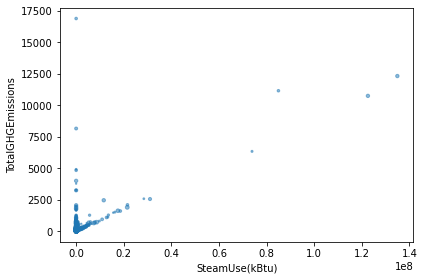

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 289259483.69308704

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.112, p=0.161
Probablement indépendant

Electricity(kWh)


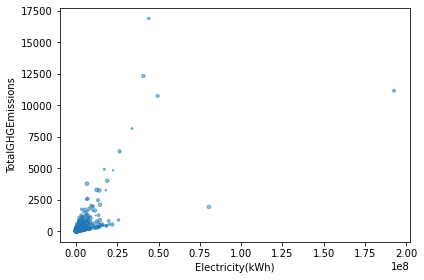

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 5159768295.286239

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.669, p=0.000
Probablement dépendant

Electricity(kBtu)


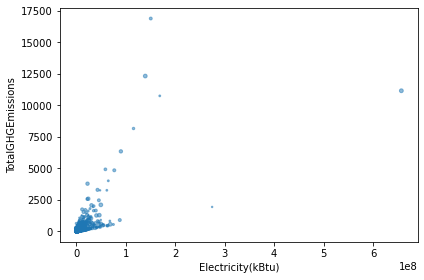

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 17605128313.686462

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.669, p=0.000
Probablement dépendant

NaturalGas(therms)


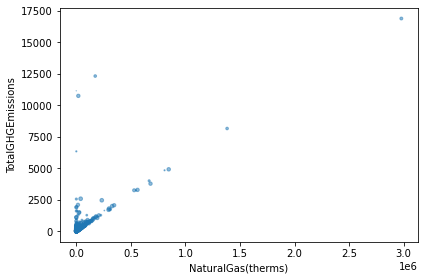

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 328320106.9849148

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.991, p=0.000
Probablement dépendant

NaturalGas(kBtu)


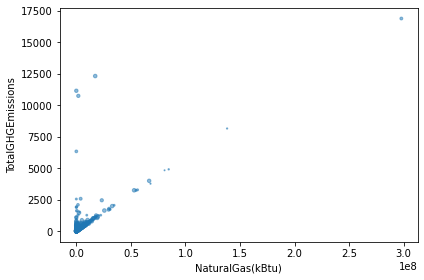

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 32832010724.45342

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.991, p=0.000
Probablement dépendant

TotalGHGEmissions


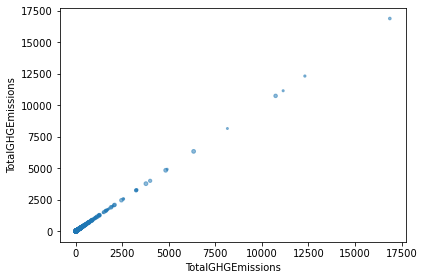

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 1888768.012479314

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=1.000, p=0.000
Probablement dépendant

GHGEmissionsIntensity


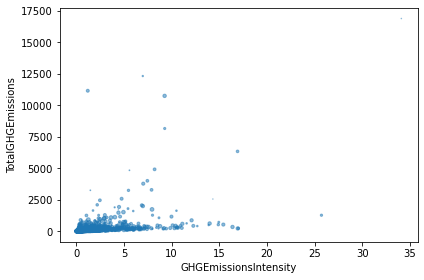

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 3699.2150111120127

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.953, p=0.000
Probablement dépendant

Usage_nb


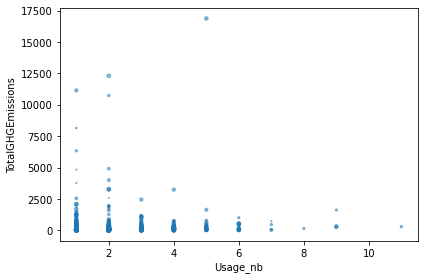

-----------------------------------------------------------
Covariance
-----------------------------------------------------------
Covariance: 200.95867945961297

-----------------------------------------------------------
Coefficient de corrélation Pearson
-----------------------------------------------------------
stat=0.140, p=0.080
Probablement indépendant



In [105]:
for column in column_list:
    print(column)
    bivarie_scatter(data, column, 'TotalGHGEmissions')
    test_stat_continue_continue(
        data.dropna(), column, 'TotalGHGEmissions', 100)

   ## Final cleaning

### Data leak

In [106]:
sup_list = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
            'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
            'NaturalGas(therms)', 'NaturalGas(kBtu)', 'GHGEmissionsIntensity'
            ]

for column in sup_list:
    data = data.drop(column, 1)
print(data.shape)

(1573, 19)


# Save dataframe

In [107]:
data.to_csv('2015_2016_building_energy_benchmarking.csv',
            sep=',', decimal='.',
            encoding='utf8', index=False)